In [1]:
import os
import datetime
from importlib import reload
import pickle
from itertools import combinations

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from scipy.stats import percentileofscore
import seaborn as sns
import matplotlib.pyplot as plt

import helpers as hp

%matplotlib inline
pd.options.display.max_columns = 150

In [137]:
reload(hp)

<module 'helpers' from 'C:\\Users\\Steve\\Documents\\current_projects\\bts\\helpers.py'>

## Data Set up

In [43]:
# load dataset for selected players
df_hitters = pd.read_csv('select_players.csv')
df = hp.load_analysis_set(1)
df = pd.merge(df, df_hitters, how = 'left', on = 'name')
df.dropna(subset = ['player_id'], inplace = True)
df.to_csv('data/analysis_2_.csv', index = False)

# construct model meta data file
model_meta = {}
for i, row in df_hitters.iterrows():
    model_meta[row.player_id] = {}
    model_meta[row.player_id]['name'] = row['name']
    model_meta[row.player_id]['features'] = []
with open('models/meta_2_.pickle', 'wb') as f:
    pickle.dump(model_meta, f)

## p7 Hitting

Hitting stats for the past 7 days.

In [102]:
# load checkpoint data
df = hp.load_analysis_set(2)
model_meta = hp.load_meta_data(2)

# join p7 hit data
temp_df = hp.load_data('hitting/week_master','p7')
right_variables = ['p7__Date','p7__Team','p7__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'team_fg','name'],
                right_on=right_variables)
df.drop(['p7__Date', 'p7__Season', 'p7__Name', 'p7__Team'], inplace = True, axis = 1)
df.dropna(inplace = True )

In [103]:
model_meta = hp.pick_features(df, 'p7__', model_meta)

Calculating Model 0,['p7__AVG', 'p7__OBP']
Calculating Model 1,['p7__BB%', 'p7__BB/K']
Calculating Model 2,['p7__PA', 'p7__BB/K']
Calculating Model 3,['p7__BB%', 'p7__K%']
Calculating Model 4,['p7__wRAA', 'p7__wOBA']
Calculating Model 5,['p7__PA', 'p7__OBP']
Calculating Model 6,['p7__AVG', 'p7__OPS']
Calculating Model 7,['p7__BABIP', 'p7__wOBA']
Calculating Model 8,['p7__K%', 'p7__BB/K']
Calculating Model 9,['p7__BB%', 'p7__BB/K']
Calculating Model 10,['p7__SLG', 'p7__ISO']
Calculating Model 11,['p7__BB%', 'p7__K%']
Calculating Model 12,['p7__BB%', 'p7__ISO']
Calculating Model 13,['p7__K%', 'p7__ISO']
Calculating Model 14,['p7__AVG', 'p7__SLG']
Calculating Model 15,['p7__K%', 'p7__OPS']
Calculating Model 16,['p7__PA', 'p7__K%']
Calculating Model 17,['p7__BB%', 'p7__wRC']
Calculating Model 18,['p7__ISO', 'p7__wRC']
Calculating Model 19,['p7__OPS', 'p7__wRC+']
Calculating Model 20,['p7__BABIP', 'p7__wRAA']
Calculating Model 21,['p7__PA', 'p7__BB%']
Calculating Model 22,['p7__SLG', 'p7__w

In [138]:
df, model_meta = hp.construct_models(df, model_meta)

Calculating Model 0 - Adam Eaton, Precision = 0.8
Calculating Model 1 - Adam Jones, Precision = 0.634920634921
Calculating Model 2 - Adrian Beltre, Precision = 0.611111111111
Calculating Model 3 - Alcides Escobar, Precision = 0.815789473684
Calculating Model 4 - Andrew McCutchen, Precision = 0.75
Calculating Model 5 - Anthony Rendon, Precision = 0.838709677419
Calculating Model 6 - Anthony Rizzo, Precision = 0.833333333333
Calculating Model 7 - Brandon Phillips, Precision = 0.827586206897
Calculating Model 8 - Buster Posey, Precision = 0.764705882353
Calculating Model 9 - Charlie Blackmon, Precision = 0.666666666667
Calculating Model 10 - Christian Yelich, Precision = 0.75
Calculating Model 11 - DJ LeMahieu, Precision = 0.675675675676
Calculating Model 12 - Daniel Murphy, Precision = 0.8
Calculating Model 13 - Dee Gordon, Precision = 0.892857142857
Calculating Model 14 - Dustin Pedroia, Precision = 0.862068965517
Calculating Model 15 - Elvis Andrus, Precision = 0.837837837838
Calculati

In [168]:
hp.target_percent(df)

73.61

In [159]:
features = ['probs', 'model_precision', 'sample_size']
poly = PolynomialFeatures(interaction_only=True)
df_input = pd.DataFrame(poly.fit_transform(df[features]), index = df.index)
lgr = LogisticRegression()
y = df.loc[df.model_set == 'dev','got_hit'].tolist()
lgr.fit(df_input[df.model_set == 'dev'], y)
dev_probs = lgr.predict_proba(df_input[df.model_set == 'dev'])[:,1]
test_probs = lgr.predict_proba(df_input[df.model_set == 'test'])[:,1]

In [169]:
y = df.loc[df.model_set == 'dev','got_hit'].tolist()
thresh = np.percentile(dev_probs, 73)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=y, digits = 3))

             precision    recall  f1-score   support

      False      0.294     0.765     0.424      2181
       True      0.756     0.284     0.412      5600

avg / total      0.626     0.418     0.416      7781



In [177]:
y = df.loc[df.model_set == 'test','got_hit'].tolist()
print(metrics.classification_report(y_pred=(test_probs >= thresh), y_true=y, digits = 3))

             precision    recall  f1-score   support

      False      0.280     0.738     0.406       526
       True      0.743     0.285     0.412      1396

avg / total      0.616     0.409     0.410      1922



C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


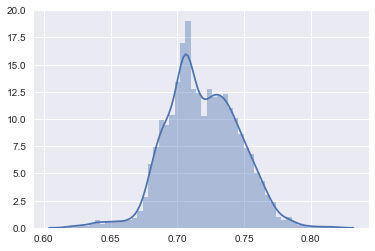

In [205]:
sns.distplot(dev_probs)

In [204]:
c1 = (test_probs > thresh)
c2 = np.array(y) == False
df_misses = df[df.model_set == 'test'].reset_index()[c1 & c2]
df_misses['final_probs'] = test_probs[c1 & c2]
df_misses

,index,date,home,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,hit_pct_meta,sample_size,player_id,p7__PA,p7__BB%,p7__K%,p7__BB/K,p7__AVG,p7__OBP,p7__SLG,p7__OPS,p7__ISO,p7__BABIP,p7__wRC,p7__wRAA,p7__wOBA,p7__wRC+,probs,model_precision,final_probs
1,18431,2014-07-07,False,Chicago White Sox @ Boston Red Sox,Clay Buchholz,False,Boston Red Sox,Scott Carroll,False,Chicago White Sox,2014-07-06,CHW,BOS,False,Adam Eaton,test,138734.0,0.715640,422.0,11205.0,31.0,12.9,16.1,0.8,0.148,0.258,0.222,0.480,0.074,0.182,1.0,-1.9,0.229,40.0,72.252747,0.800000,0.744623
15,19018,2014-09-02,False,Chicago White Sox @ Minnesota Twins,Tommy Milone,True,Minnesota Twins,Hector Noesi,False,Chicago White Sox,2014-09-01,CHW,MIN,False,Adam Eaton,test,143080.0,0.715640,422.0,11205.0,32.0,9.4,6.3,1.5,0.393,0.452,0.571,1.023,0.179,0.423,7.0,3.3,0.445,191.0,95.329670,0.800000,0.758174
22,19245,2016-07-27,False,Chicago White Sox @ Chicago Cubs,Jason Hammel,False,Chicago Cubs,Anthony Ranaudo,False,Chicago White Sox,2016-07-26,CHW,CHC,False,Adam Eaton,test,144785.0,0.715640,422.0,11205.0,36.0,13.9,22.2,0.6,0.300,0.417,0.533,0.950,0.233,0.350,7.0,2.7,0.409,159.0,69.230769,0.800000,0.742812
125,18317,2016-09-30,True,Cleveland Indians @ Kansas City Royals,Ryan Merritt,True,Cleveland Indians,Yordano Ventura,False,Kansas City Royals,2016-09-29,KCR,CLE,False,Alcides Escobar,test,137936.0,0.713062,467.0,6310.0,28.0,0.0,21.4,0.0,0.185,0.179,0.296,0.475,0.111,0.190,1.0,-2.8,0.197,13.0,60.243902,0.815789,0.742708
127,18344,2016-07-08,True,Seattle Mariners @ Kansas City Royals,Hisashi Iwakuma,False,Seattle Mariners,Yordano Ventura,False,Kansas City Royals,2016-07-07,KCR,SEA,False,Alcides Escobar,test,138123.0,0.713062,467.0,6310.0,29.0,6.9,6.9,1.0,0.259,0.310,0.407,0.718,0.148,0.280,3.0,-0.2,0.309,89.0,70.000000,0.815789,0.746276
129,18429,2016-09-21,False,Kansas City Royals @ Cleveland Indians,Corey Kluber,False,Cleveland Indians,Ian Kennedy,False,Kansas City Royals,2016-09-20,KCR,CLE,False,Alcides Escobar,test,138721.0,0.713062,467.0,6310.0,25.0,4.0,16.0,0.3,0.261,0.320,0.565,0.885,0.304,0.278,4.0,1.0,0.368,130.0,50.121951,0.815789,0.738973
137,18880,2016-09-28,True,Minnesota Twins @ Kansas City Royals,Ervin Santana,False,Minnesota Twins,Jason Vargas,True,Kansas City Royals,2016-09-27,KCR,MIN,False,Alcides Escobar,test,142016.0,0.713062,467.0,6310.0,27.0,0.0,22.2,0.0,0.154,0.148,0.269,0.417,0.115,0.150,0.0,-3.2,0.172,-5.0,59.512195,0.815789,0.742439
144,19154,2014-06-15,False,Kansas City Royals @ Chicago White Sox,Andre Rienzo,False,Chicago White Sox,James Shields,False,Kansas City Royals,2014-06-14,KCR,CHW,False,Alcides Escobar,test,144102.0,0.713062,467.0,6310.0,23.0,4.3,4.3,1.0,0.429,0.435,0.524,0.959,0.095,0.429,4.0,1.8,0.413,167.0,90.487805,0.815789,0.753660
145,19273,2014-06-25,True,Los Angeles Dodgers @ Kansas City Royals,Dan Haren,False,Los Angeles Dodgers,James Shields,False,Kansas City Royals,2014-06-24,KCR,LAD,False,Alcides Escobar,test,144964.0,0.713062,467.0,6310.0,26.0,0.0,19.2,0.0,0.280,0.308,0.360,0.668,0.080,0.350,3.0,-0.3,0.296,86.0,54.390244,0.815789,0.740552
154,19769,2016-09-16,True,Chicago White Sox @ Kansas City Royals,Chris Sale,True,Chicago White Sox,Ian Kennedy,False,Kansas City Royals,2016-09-15,KCR,CHW,False,Alcides Escobar,test,149149.0,0.713062,467.0,6310.0,24.0,4.2,29.2,0.1,0.318,0.375,0.455,0.830,0.136,0.467,4.0,0.8,0.359,124.0,69.512195,0.815789,0.746098


C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


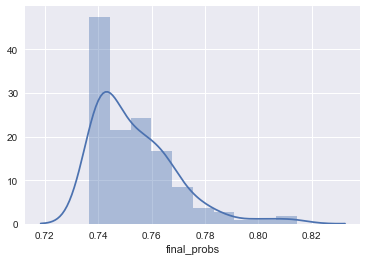

In [207]:
sns.distplot(df_misses.final_probs)

In [208]:
df.to_csv('data/analysis_3_.csv', index = False)
with open('models/meta_3_.pickle', 'wb') as f:
    pickle.dump(model_meta, f)

## Opposing Pitcher

In [209]:
# load checkpoint data
df = hp.load_analysis_set(3)
model_meta = hp.load_meta_data(3)

#load some pitcher stats from previous three games
temp_df = hp.load_data('pitching/past_3games_batted_balls_master','opp_pitcher_battedballs_p3')
right_variables = ['opp_pitcher_battedballs_p3__Date','opp_pitcher_battedballs_p3__Team','opp_pitcher_battedballs_p3__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher'],
                right_on=right_variables)

temp_df = hp.load_data('pitching/past_3games_master','opp_pitcher_p3')
right_variables = ['opp_pitcher_p3__Date','opp_pitcher_p3__Team','opp_pitcher_p3__Name']
temp_df = temp_df.drop_duplicates(subset=right_variables)
df = pd.merge(df,temp_df,
                how = 'left', 
                left_on=['date_m1', 'opp_team_fg','opp_pitcher'],
                right_on=right_variables)
drop_cols = ['opp_pitcher_battedballs_p3__Season', 
             'opp_pitcher_battedballs_p3__Name', 
             'opp_pitcher_battedballs_p3__Team', 
             'opp_pitcher_battedballs_p3__Date', 
             'opp_pitcher_p3__Season', 
             'opp_pitcher_p3__Name', 
             'opp_pitcher_p3__Team', 
             'opp_pitcher_p3__Date']
df.drop(drop_cols, axis = 1, inplace = True)

In [219]:
# if pitcher stats are missing it means they didnt play in the past three games or so
# significant difference in dependent variable, so not wise to drop
df['remove'] = df.opp_pitcher_p3__Name.isnull()
df.groupby('remove').got_hit.mean()
df.drop('remove', axis = 1, inplace = True)

# fill missing with 
df.opp_pitcher_battedballs_p3__IP.fillna(0, inplace = True)
df.opp_pitcher_p3__IP.fillna(0, inplace = True)
df = hp.impute_na(df)

remove
False    0.715790
True     0.752326
Name: got_hit, dtype: float64

In [234]:
model_meta = hp.pick_features(df, 'opp_pitcher_', model_meta, n_features=3)

Calculating Model 0,['opp_pitcher_battedballs_p3__IP', 'opp_pitcher_battedballs_p3__Oppo%', 'opp_pitcher_p3__K/9']
Calculating Model 1,['opp_pitcher_lefty', 'opp_pitcher_battedballs_p3__IP', 'opp_pitcher_battedballs_p3__Hard%']
Calculating Model 2,['opp_pitcher_battedballs_p3__IP', 'opp_pitcher_p3__K/9', 'opp_pitcher_p3__WHIP']
Calculating Model 3,['opp_pitcher_lefty', 'opp_pitcher_battedballs_p3__BUH%', 'opp_pitcher_battedballs_p3__Med%']
Calculating Model 4,['opp_pitcher_lefty', 'opp_pitcher_battedballs_p3__Oppo%', 'opp_pitcher_p3__K/9']
Calculating Model 5,['opp_pitcher_battedballs_p3__IP', 'opp_pitcher_battedballs_p3__Hard%', 'opp_pitcher_p3__LOB%']
Calculating Model 6,['opp_pitcher_battedballs_p3__IFFB%', 'opp_pitcher_battedballs_p3__Oppo%', 'opp_pitcher_battedballs_p3__Soft%']
Calculating Model 7,['opp_pitcher_battedballs_p3__IP', 'opp_pitcher_battedballs_p3__Pull%', 'opp_pitcher_battedballs_p3__Soft%']
Calculating Model 8,['opp_pitcher_battedballs_p3__IFFB%', 'opp_pitcher_p3__K/

In [250]:
df, model_meta = hp.construct_models(df, model_meta)

Calculating Model 0 - Adam Eaton, Precision = 0.862068965517
Calculating Model 1 - Adam Jones, Precision = 0.833333333333
Calculating Model 2 - Adrian Beltre, Precision = 0.722222222222
Calculating Model 3 - Alcides Escobar, Precision = 0.789473684211
Calculating Model 4 - Andrew McCutchen, Precision = 0.75
Calculating Model 5 - Anthony Rendon, Precision = 0.866666666667
Calculating Model 6 - Anthony Rizzo, Precision = 0.7
Calculating Model 7 - Brandon Phillips, Precision = 0.758620689655
Calculating Model 8 - Buster Posey, Precision = 0.852941176471
Calculating Model 9 - Charlie Blackmon, Precision = 0.833333333333
Calculating Model 10 - Christian Yelich, Precision = 0.71875
Calculating Model 11 - DJ LeMahieu, Precision = 0.756756756757
Calculating Model 12 - Daniel Murphy, Precision = 0.862068965517
Calculating Model 13 - Dee Gordon, Precision = 0.928571428571
Calculating Model 14 - Dustin Pedroia, Precision = 0.758620689655
Calculating Model 15 - Elvis Andrus, Precision = 0.64864864

In [251]:
hp.target_percent(df)

73.61

In [261]:
features = ['probs', 'model_precision', 'sample_size']
poly = PolynomialFeatures(interaction_only=True)
df_input = pd.DataFrame(poly.fit_transform(df[features]), index = df.index)
df_input = df[features]
lgr = LogisticRegression()
y = df.loc[df.model_set == 'dev','got_hit'].tolist()
lgr.fit(df_input[df.model_set == 'dev'], y)
dev_probs = lgr.predict_proba(df_input[df.model_set == 'dev'])[:,1]
test_probs = lgr.predict_proba(df_input[df.model_set == 'test'])[:,1]

In [267]:
y = df.loc[df.model_set == 'dev','got_hit'].tolist()
thresh = np.percentile(dev_probs, 72)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=y, digits = 3))

             precision    recall  f1-score   support

      False      0.303     0.778     0.436      2181
       True      0.778     0.303     0.436      5600

avg / total      0.645     0.436     0.436      7781



In [263]:
y = df.loc[df.model_set == 'test','got_hit'].tolist()
print(metrics.classification_report(y_pred=(test_probs >= thresh), y_true=y, digits = 3))

             precision    recall  f1-score   support

      False      0.277     0.732     0.402       526
       True      0.734     0.279     0.405      1396

avg / total      0.609     0.403     0.404      1922



In [308]:
reload(hp)

<module 'helpers' from 'C:\\Users\\Steve\\Documents\\current_projects\\bts\\helpers.py'>

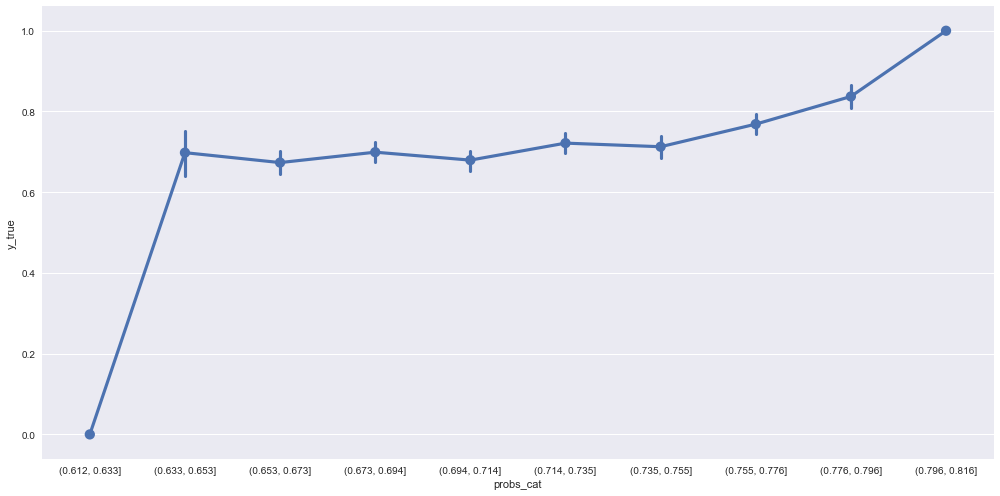

In [309]:
y_true = df.loc[df.model_set == 'dev','got_hit'].tolist()
hp.calibration_histogram(dev_probs, y_true, n_split=50)

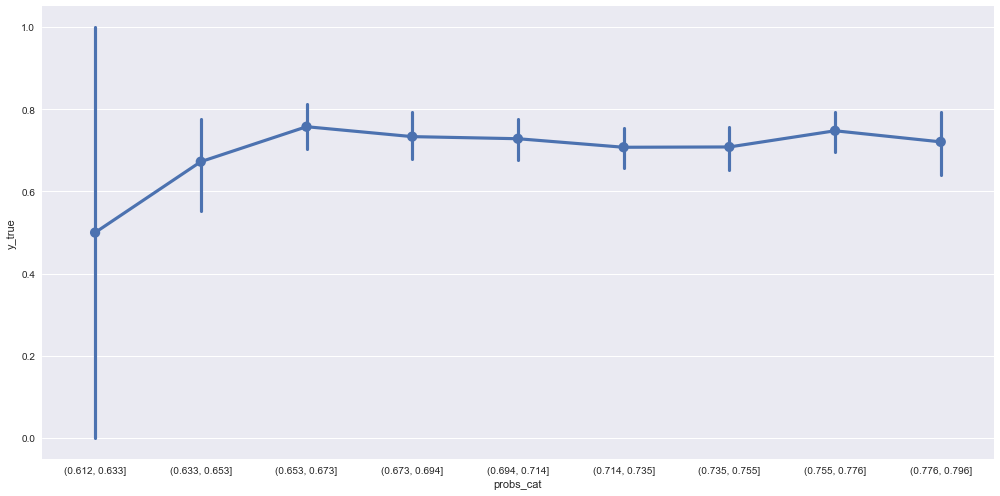

In [310]:
y_true = df.loc[df.model_set == 'test','got_hit'].tolist()
hp.calibration_histogram(test_probs, y_true, n_split=50)

In [268]:
df.to_csv('data/analysis_4_.csv', index = False)
with open('models/meta_4_.pickle', 'wb') as f:
    pickle.dump(model_meta, f)

Things to do:
1. Incorporate additional data, and more players.
2. Adjust feature selection function. Once x best variables are found, iterate through the combination of those to see if some can be removed.
3. Add batted balls to hitter stats.
4. Add history against pitcher.
5. Add more variables to go in meta model. Month, weekday, in division, interleague.
6. Try p7 team stats and bullpen.

In [119]:
pd.Series(np.array([3,2,1])).tolist()

[3, 2, 1]

In [82]:
model_meta.keys()

dict_keys([11205, 6368, 639, 6310, 9847, 12861, 3473, 791, 9166, 7859, 11477, 9874, 4316, 8203, 8370, 8709, 4922, 3516, 9368, 12916, 8252, 6195, 6184, 4556, 9776, 1857, 4314, 15676, 5417, 1736, 15429, 9077, 11493, 3312, 4022, 4106, 1744, 10155, 13611, 2434, 5930, 9777, 9218, 4613, 3269, 3410, 3531, 393, 12161, 13110])

In [92]:
model_meta[11493]

{'features': ['p7__wOBA', 'p7__wRC+'], 'name': 'Manny Machado'}

In [70]:
model_meta = pick_features(df, 'p7__', model_meta)

Calculating Model 0


ValueError: Can't handle mix of binary and multilabel-indicator

In [42]:
row.name

49

In [45]:
model_meta[11205]

{'features': [], 'name': 'Adam Eaton'}

In [18]:
df.head(2)

,date,home,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,hit_pct_meta,sample_size,player_id
1,2016-05-09,True,Arizona Diamondbacks @ Colorado Rockies,Archie Bradley,False,Arizona Diamondbacks,Tyler Chatwood,False,Colorado Rockies,2016-05-08,COL,ARI,True,Nolan Arenado,train,1,0.717703,418.0,9777.0
9,2014-08-17,True,Cincinnati Reds @ Colorado Rockies,Mat Latos,False,Cincinnati Reds,Jordan Lyles,False,Colorado Rockies,2014-08-16,COL,CIN,True,Charlie Blackmon,train,9,0.723356,441.0,7859.0


In [12]:
df.shape

(152548, 16)

In [16]:
df.shape

(18148, 19)

In [14]:
df.shape

(152548, 19)

In [9]:
df_hitters.name

0           Adam Eaton
1           Adam Jones
2        Adrian Beltre
3      Alcides Escobar
4     Andrew McCutchen
5       Anthony Rendon
6        Anthony Rizzo
7     Brandon Phillips
8         Buster Posey
9     Charlie Blackmon
10    Christian Yelich
11         DJ LeMahieu
12       Daniel Murphy
13          Dee Gordon
14      Dustin Pedroia
15        Elvis Andrus
16      Ender Inciarte
17         Eric Hosmer
18       Evan Longoria
19    Francisco Lindor
20        Hunter Pence
21         Ian Kinsler
22       J.D. Martinez
23         James Loney
24        Jason Kipnis
25           Joe Mauer
26          Joey Votto
27          Jose Abreu
28         Jose Altuve
29          Jose Reyes
30         Kris Bryant
31        Lorenzo Cain
32       Manny Machado
33        Martin Prado
34       Melky Cabrera
35    Michael Brantley
36      Miguel Cabrera
37          Mike Trout
38        Mookie Betts
39         Nelson Cruz
40       Nick Markakis
41       Nolan Arenado
42    Paul Goldschmidt
43      Pri